# Lecture 10: Frequentist Basics

This notebook demonstrates key frequentist methods:
- Point estimation (mean and variance)
- Maximum likelihood estimation (MLE) vs. unbiased estimators
- Confidence intervals and coverage
- Frequentist linear regression
- Comparisons with Bayesian methods where relevant

Each step is clearly marked, and we use consistent datasets throughout.

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import arviz as az
import pymc as pm
import bambi as bmb

az.style.use("arviz-whitegrid")
plt.rc("figure", dpi=150)
np.random.seed(123)

## 1. Mean and Variance Estimators

We use the chemical shifts dataset for all examples.

In [3]:
url = "https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data/chemical_shifts_theo_exp.csv"
cs_data = pd.read_csv(url)
diff = cs_data.theo - cs_data.exp

In [4]:
trimming = 0.2

sample_mean = np.mean(diff)
trimmed_mean = stats.trim_mean(diff, trimming)
sample_median = np.median(diff)
# Calculate additional statistics
sample_size = len(diff)
print(f"Sample Mean: {sample_mean:.4f}")
print(f"Trimmed Mean: {trimmed_mean:.4f}")
print(f"Sample Median: {sample_median:.4f}")

Sample Mean: 0.0516
Trimmed Mean: 0.0767
Sample Median: 0.0700


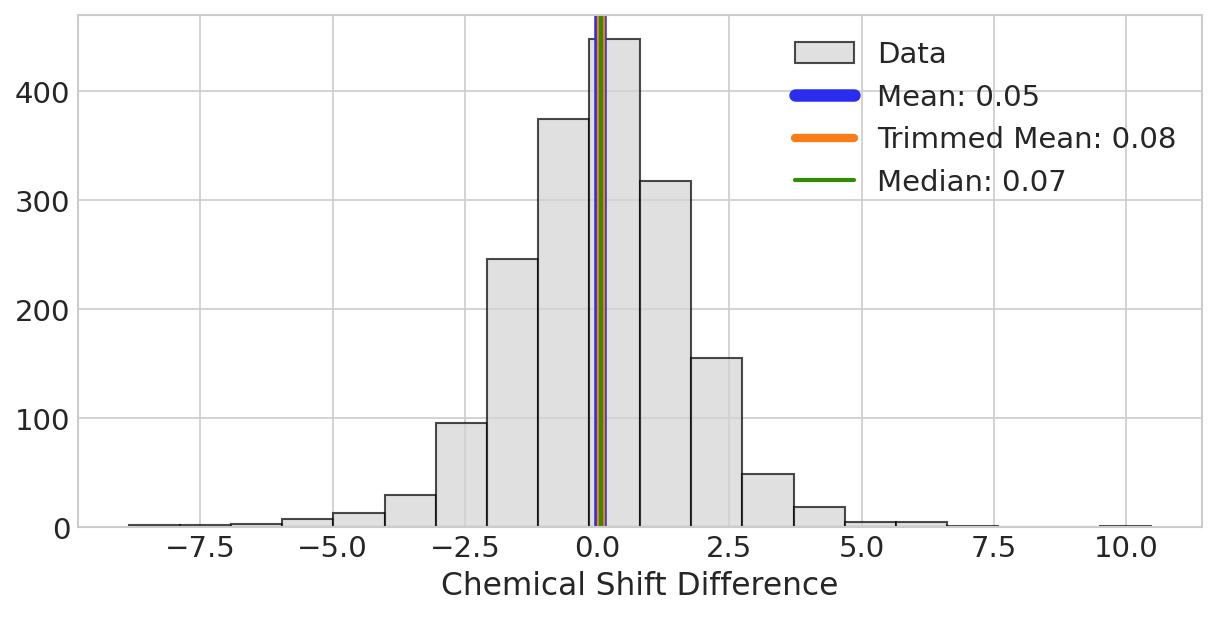

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(diff, bins=20, color='lightgray', edgecolor='black', alpha=0.7, label='Data')

sample_mean = np.mean(diff)
trimmed_mean = stats.trim_mean(diff, trimming)
sample_median = np.median(diff)

ax.axvline(sample_mean, color='C0', label=f'Mean: {sample_mean:.2f}', linewidth=6)
ax.axvline(trimmed_mean, color='C1', label=f'Trimmed Mean: {trimmed_mean:.2f}', linewidth=4)
ax.axvline(sample_median, color='C2', label=f'Median: {sample_median:.2f}', linewidth=2)

ax.set_xlabel('Chemical Shift Difference')
ax.legend()
plt.show()

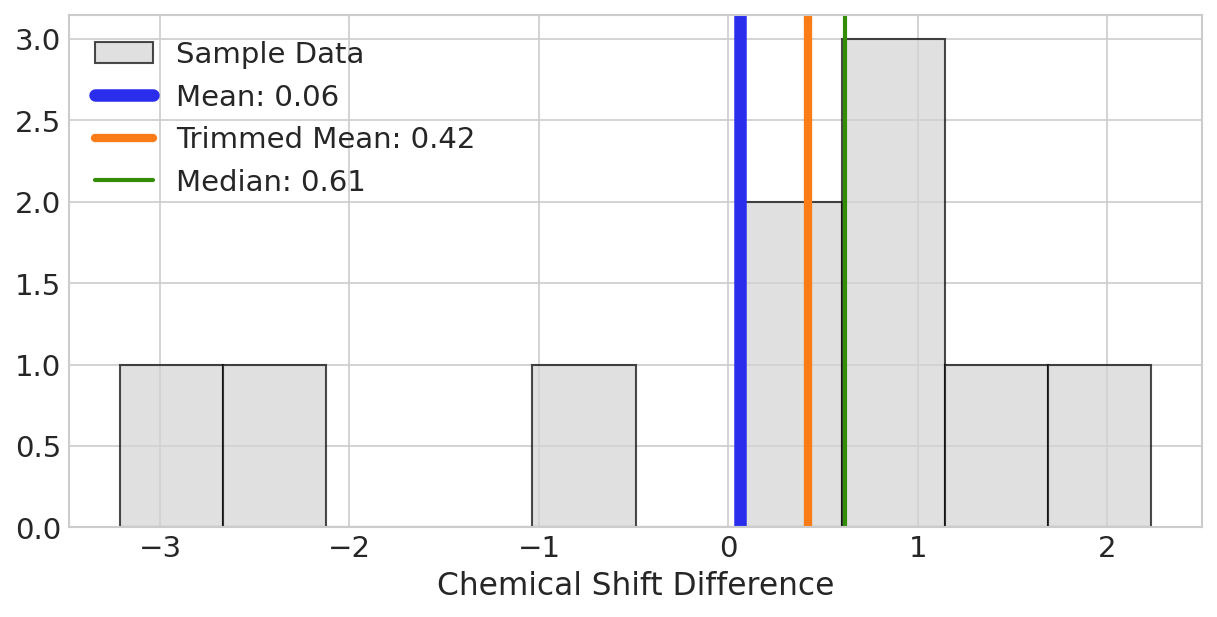

In [6]:
np.random.seed(456)
diff_sample = np.random.choice(diff, size=10, replace=False)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(diff_sample, bins=10, color='lightgray', edgecolor='black', alpha=0.7, label='Sample Data')

sample_mean_sample = np.mean(diff_sample)
trimmed_mean_sample = stats.trim_mean(diff_sample, trimming)
sample_median_sample = np.median(diff_sample)

ax.axvline(sample_mean_sample, color='C0', label=f'Mean: {sample_mean_sample:.2f}', linewidth=6)
ax.axvline(trimmed_mean_sample, color='C1', label=f'Trimmed Mean: {trimmed_mean_sample:.2f}', linewidth=4)
ax.axvline(sample_median_sample, color='C2', label=f'Median: {sample_median_sample:.2f}', linewidth=2)

ax.set_xlabel('Chemical Shift Difference')
ax.legend()
plt.show()

In [7]:
std_unbiased = np.std(diff, ddof=1)
std_mle = np.std(diff, ddof=0)
iqr = stats.iqr(diff) / 1.349
wdiff = diff.copy()
winsorized_sample = stats.mstats.winsorize(wdiff, limits=0.1)
winsorized_sd = np.std(winsorized_sample, ddof=1)

print(f"Sample Standard Deviation (Unbiased): {std_unbiased:.4f}")
print(f"Sample Standard Deviation (MLE): {std_mle:.4f}")
print(f"IQR-based Estimate: {iqr:.4f}")
print(f"Winsorized Standard Deviation: {winsorized_sd:.4f}")

Sample Standard Deviation (Unbiased): 1.7261
Sample Standard Deviation (MLE): 1.7256
IQR-based Estimate: 1.5382
Winsorized Standard Deviation: 1.2889


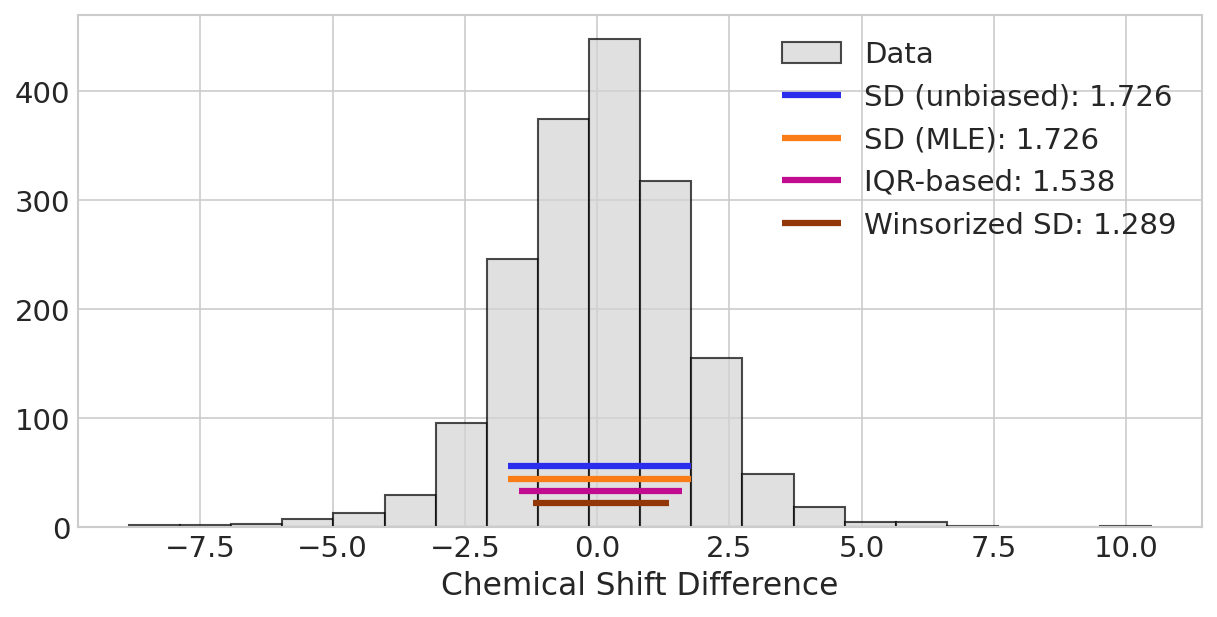

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))

counts, bins, patches = ax.hist(diff, bins=20, color='lightgray', edgecolor='black', alpha=0.7, label='Data')

max_count = counts.max()
y_height = max_count * 0.05

ax.hlines(y_height * 2.5, sample_mean - std_unbiased, sample_mean + std_unbiased, color='C0', linewidth=3, label=f'SD (unbiased): {std_unbiased:.3f}')
ax.hlines(y_height * 2.0, sample_mean - std_mle, sample_mean + std_mle, color='C1', linewidth=3, label=f'SD (MLE): {std_mle:.3f}')
ax.hlines(y_height * 1.5, sample_median - iqr, sample_median + iqr, color='C3', linewidth=3, label=f'IQR-based: {iqr:.3f}')
ax.hlines(y_height * 1.0, trimmed_mean - winsorized_sd, trimmed_mean + winsorized_sd, color='C4', linewidth=3, label=f'Winsorized SD: {winsorized_sd:.3f}')

ax.set_xlabel('Chemical Shift Difference')
ax.legend()
plt.show()

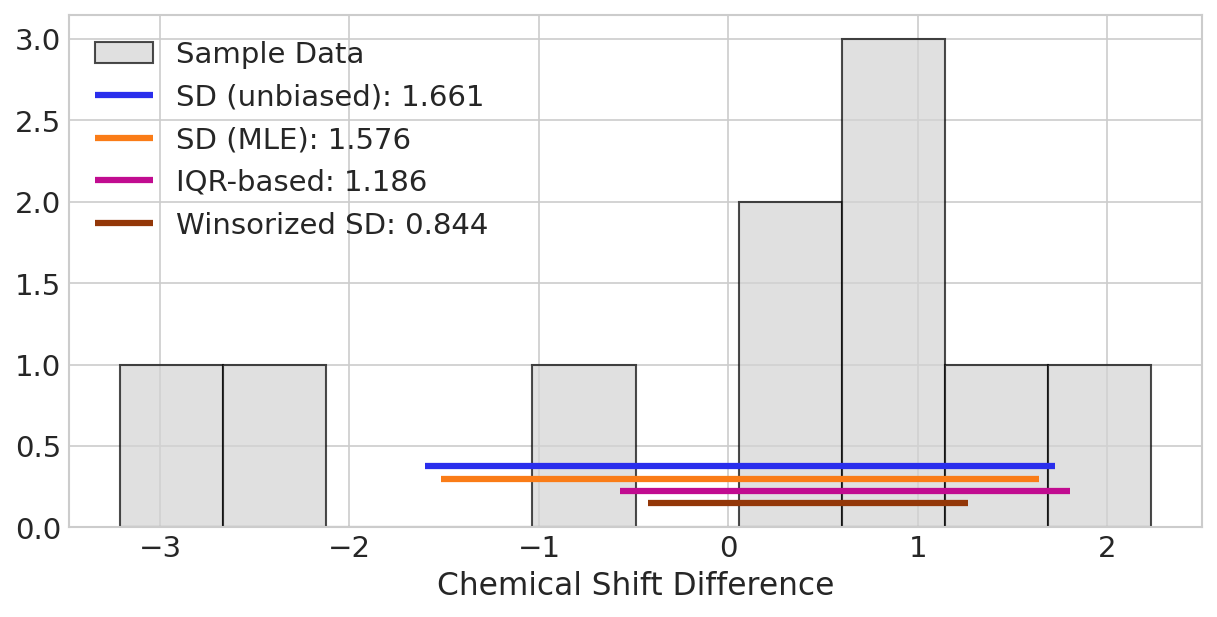

In [9]:
std_unbiased_sample = np.std(diff_sample, ddof=1)
std_mle_sample = np.std(diff_sample, ddof=0)
iqr_sample = stats.iqr(diff_sample) / 1.349
wdiff_sample = diff_sample.copy()
winsorized_sample_small = stats.mstats.winsorize(wdiff_sample, limits=trimming)
winsorized_sd_sample = np.std(winsorized_sample_small, ddof=1)

fig, ax = plt.subplots(figsize=(8, 4))
counts, bins, patches = ax.hist(diff_sample, bins=10, color='lightgray', edgecolor='black', alpha=0.7, label='Sample Data')

max_count = counts.max()
y_height = max_count * 0.05

ax.hlines(y_height * 2.5, sample_mean_sample - std_unbiased_sample, sample_mean_sample + std_unbiased_sample, color='C0', linewidth=3, label=f'SD (unbiased): {std_unbiased_sample:.3f}')
ax.hlines(y_height * 2.0, sample_mean_sample - std_mle_sample, sample_mean_sample + std_mle_sample, color='C1', linewidth=3, label=f'SD (MLE): {std_mle_sample:.3f}')
ax.hlines(y_height * 1.5, sample_median_sample - iqr_sample, sample_median_sample + iqr_sample, color='C3', linewidth=3, label=f'IQR-based: {iqr_sample:.3f}')
ax.hlines(y_height * 1.0, trimmed_mean_sample - winsorized_sd_sample, trimmed_mean_sample + winsorized_sd_sample, color='C4', linewidth=3, label=f'Winsorized SD: {winsorized_sd_sample:.3f}')

ax.set_xlabel('Chemical Shift Difference')
ax.legend()
plt.show()

## 2. MLE vs. Posterior Mode

Normal model: estimate the mean via MLE and via a Bayesian posterior mode.

In [10]:
mean_mle = np.mean(diff)
std_mle = np.std(diff, ddof=0)

print(f"MLE Mean: {mean_mle:.4f}")

# Bayesian mode using PyMC
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=diff)
    trace = pm.sample(1000, tune=1000, chains=2, random_seed=123, return_inferencedata=True)

mode_mu = trace.posterior["mu"].mean().values
print(f"Posterior Mean Estimate: {mode_mu:.4f}")

MLE Mean: 0.0516


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Posterior Mean Estimate: 0.0513


C:\Users\User\AppData\Local\Temp\ipykernel_25336\2651016039.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


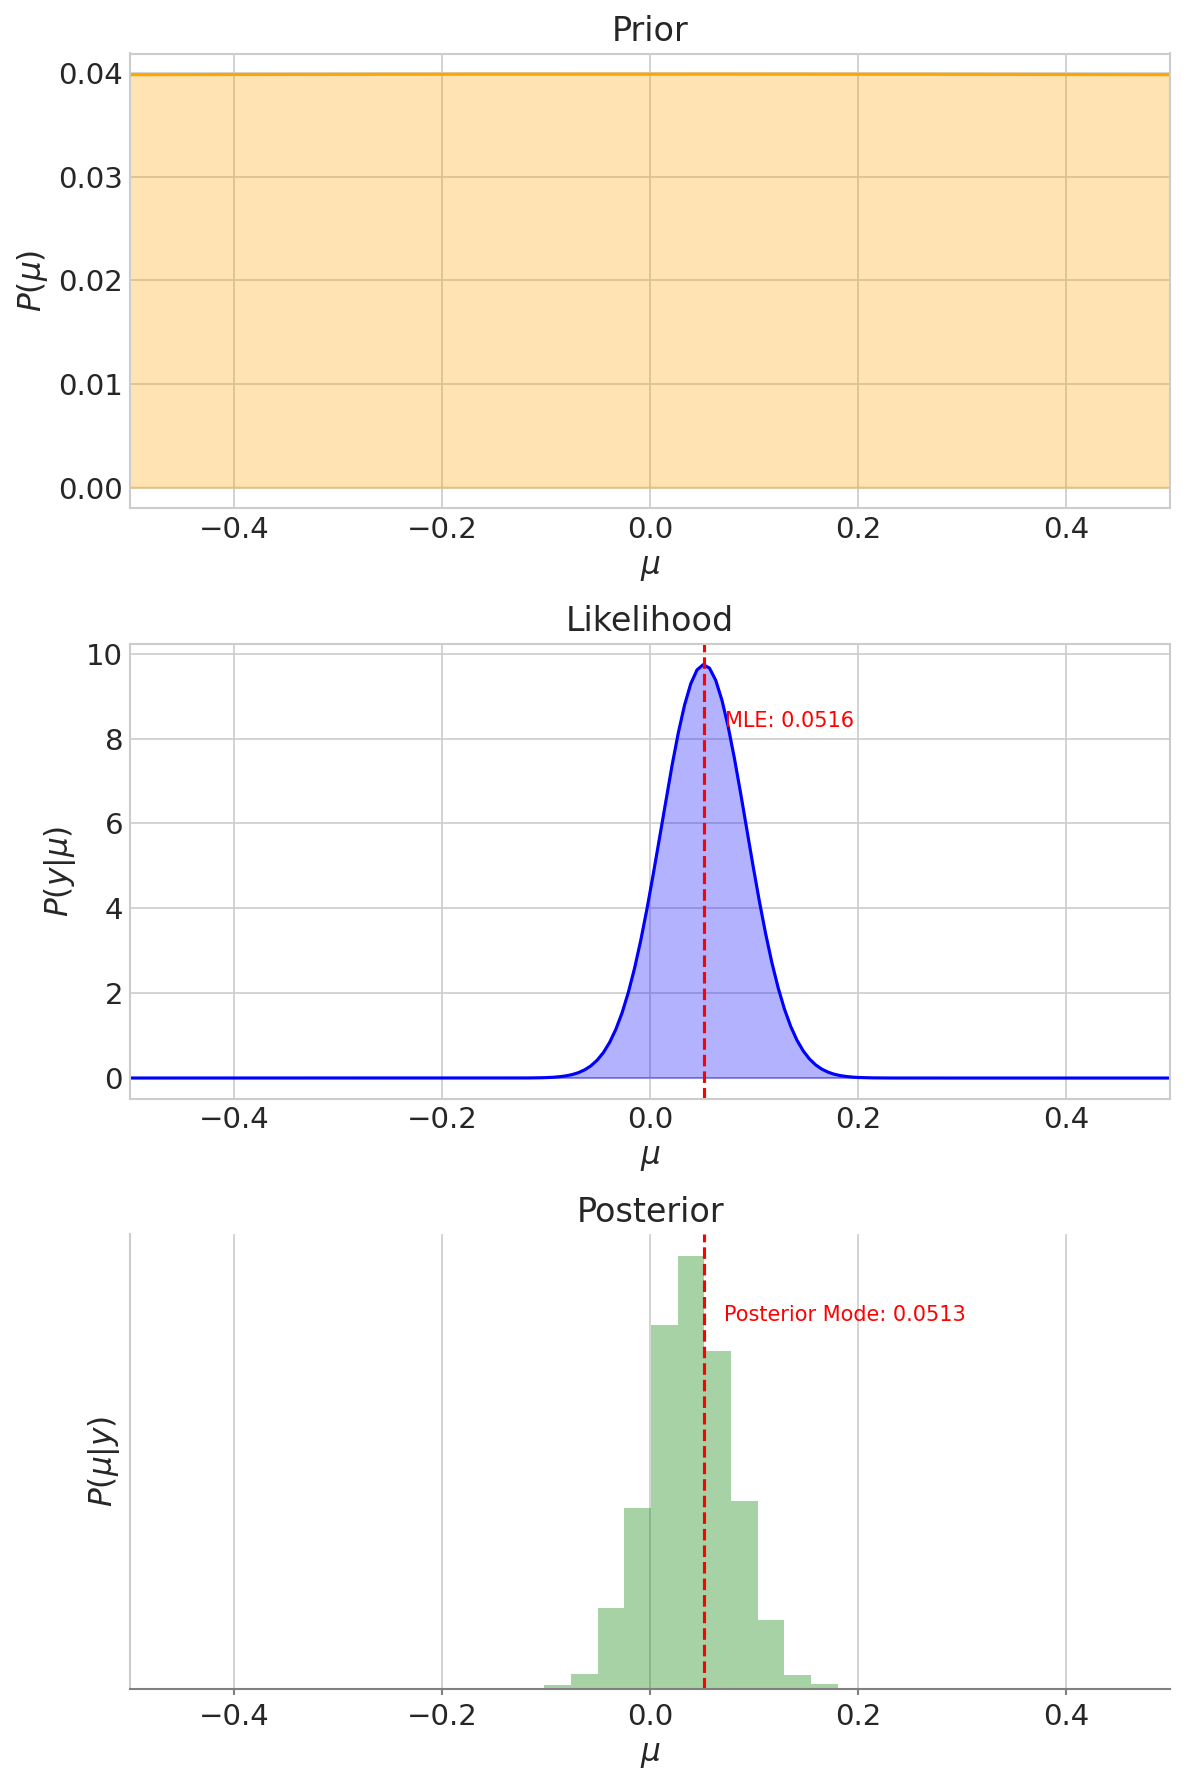

In [11]:
# Prior
mu_range = np.linspace(-3, 3, 1000)
prior_pdf = stats.norm.pdf(mu_range, loc=0, scale=10)

# Likelihood
likelihood_pdf = stats.norm.pdf(mu_range, loc=mean_mle, scale=std_mle / np.sqrt(len(diff)))

# Posterior from PyMC samples
posterior_samples = trace.posterior["mu"].values.flatten()

# Plot
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
xlim = [-0.5, 0.5]

# Prior Plot
axes[0].plot(mu_range, prior_pdf, color='orange')
axes[0].fill_between(mu_range, 0, prior_pdf, color='orange', alpha=0.3)
axes[0].set_xlim(xlim)
axes[0].set_title('Prior')
axes[0].set_xlabel(r'$\mu$')
axes[0].set_ylabel(r'$P(\mu)$')

# Likelihood Plot
axes[1].plot(mu_range, likelihood_pdf, color='blue')
axes[1].fill_between(mu_range, 0, likelihood_pdf, color='blue', alpha=0.3)
axes[1].axvline(mean_mle, color='red', linestyle='--')
axes[1].text(mean_mle+0.02, axes[1].get_ylim()[1]*0.8, f'MLE: {mean_mle:.4f}', color='red', ha='left', va='bottom')
axes[1].set_xlim(xlim)
axes[1].set_title('Likelihood')
axes[1].set_xlabel(r'$\mu$')
axes[1].set_ylabel(r'$P(y|\mu)$')

# Posterior Plot
az.plot_posterior(posterior_samples, point_estimate=None, hdi_prob='hide', kind='hist', ax=axes[2], color='green')
axes[2].axvline(mode_mu, color='red', linestyle='--')
axes[2].text(mode_mu+0.02, axes[2].get_ylim()[1]*0.8, f'Posterior Mode: {mode_mu:.4f}', color='red', ha='left', va='bottom')
axes[2].set_xlim(xlim)
axes[2].set_title('Posterior')
axes[2].set_xlabel(r'$\mu$')
axes[2].set_ylabel(r'$P(\mu|y)$')
axes[2].tick_params(axis='y', which='major')
axes[2].spines['left'].set_visible(True)
axes[2].yaxis.set_visible(True)
axes[2].grid(axis='both', visible=True)

plt.tight_layout()
plt.show()



## 3. Prior Predictive Sampling with Sharp Prior

Simulate repeated samples to show sampling distributions of mean and variance.

Sampling: [mu, sigma, y]
C:\Users\User\AppData\Local\Temp\ipykernel_25336\4109373934.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


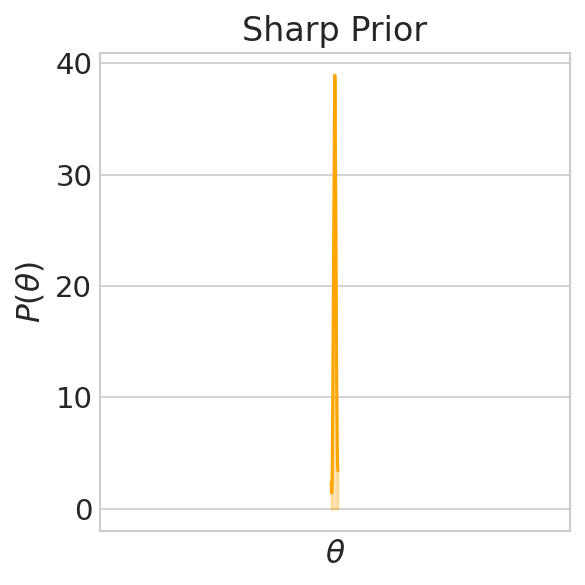

In [63]:
mu_mu = 0
sigma_mu = 0.01
sigma_y = 1
N = 20
coords = {'data_dim': np.arange(N)}
num_draws = 500

with pm.Model(coords=coords) as model:
    mu = pm.Normal('mu', mu=mu_mu, sigma=sigma_mu)
    sigma = pm.HalfNormal('sigma', sigma=sigma_y)
    y = pm.Normal('y', mu=mu, sigma=sigma, dims='data_dim', observed=None)  # will use prior predictive

    prior_pred = pm.sample_prior_predictive(samples=num_draws, random_seed=123)

mu_prior_samples = prior_pred.prior['mu'].values.flatten()

fig, ax = plt.subplots(figsize=(4, 4))
az.plot_kde(mu_prior_samples, ax=ax, fill_kwargs={'alpha':0.3, 'color':'orange'}, plot_kwargs={'color': 'orange'})
ax.set_xlim([-2, 2])
ax.set_xticks([])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$P(\theta)$')
ax.set_title('Sharp Prior')
plt.tight_layout()
plt.savefig('sharp_prior.jpg')
plt.show()

In [23]:
prior_pred

Inference data with groups:
	> prior

C:\Users\User\AppData\Local\Temp\ipykernel_25336\2867649118.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


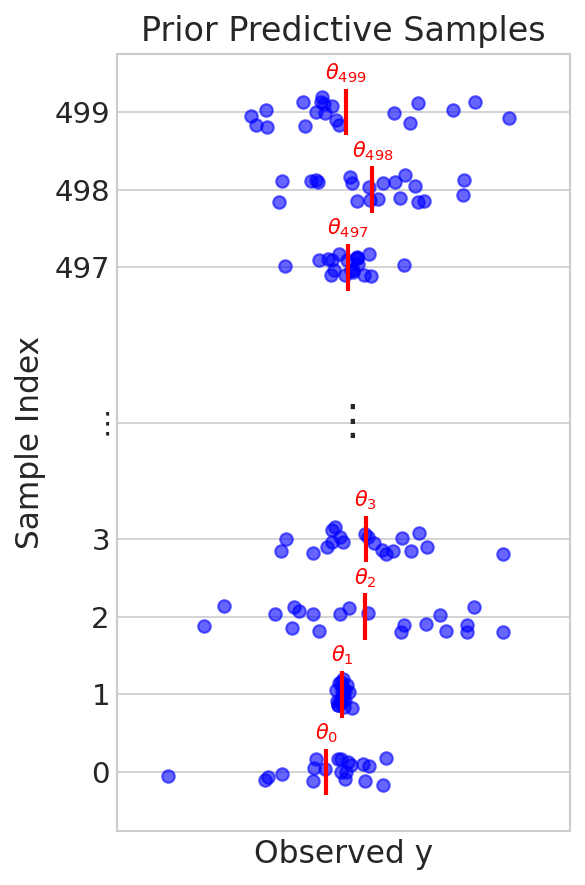

In [60]:
num_initial_draws = 4
space_between_draws = 2
num_final_draws = 3

y_prior_samples = prior_pred.prior['y']

fig, ax = plt.subplots(figsize=(4, 6))

# Plot initial draws
for i in range(num_initial_draws):
    sample_data = y_prior_samples.sel(draw=i)
    y_positions = np.full_like(sample_data, i) + np.random.uniform(-0.2, 0.2, size=sample_data.shape)
    ax.scatter(sample_data, y_positions, alpha=0.6, c='blue')
    sample_mean = sample_data.mean().item()
    ax.vlines(sample_mean, i - 0.3, i + 0.3, color='red', linewidth=2)
    ax.text(sample_mean, i + 0.35, fr'$\theta_{{{i}}}$', color='red', ha='center', va='bottom')

# Placeholder tick
gap_idx = num_initial_draws - 0.5 + (space_between_draws / 2)
ax.text(0, gap_idx, r'$\vdots$', fontsize=20, ha='center', va='center')

# Plot final draws
final_draws_indices = [num_draws - num_final_draws + i for i in range(num_final_draws)]
for idx_offset, draw_idx in enumerate(final_draws_indices):
    y_idx = gap_idx + space_between_draws + idx_offset
    sample_data = y_prior_samples.sel(draw=draw_idx)
    y_positions = np.full_like(sample_data, y_idx) + np.random.uniform(-0.2, 0.2, size=sample_data.shape)
    ax.scatter(sample_data, y_positions, alpha=0.6, c='blue')
    sample_mean = sample_data.mean().item()
    ax.vlines(sample_mean, y_idx - 0.3, y_idx + 0.3, color='red', linewidth=2)
    ax.text(sample_mean, y_idx + 0.35, fr'$\theta_{{{draw_idx}}}$', color='red', ha='center', va='bottom')

# Set y-ticks and labels
ytick_positions = list(np.arange(num_initial_draws)) + [gap_idx] + \
                  list(np.arange(start=gap_idx + space_between_draws, stop=gap_idx + space_between_draws + num_final_draws))
ytick_labels = [str(i) for i in range(num_initial_draws)] + \
               [r'$\vdots$'] + \
               [str(draw_idx) for draw_idx in final_draws_indices]
ax.set_yticks(ytick_positions)
ax.set_yticklabels(ytick_labels)

ax.set_xlim([-2, 2])
ax.set_xticks([])
ax.set_ylabel('Sample Index')
ax.set_xlabel('Observed y')
ax.set_title('Prior Predictive Samples')

plt.tight_layout()
plt.savefig('prior_predictive_samples.jpg')
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_25336\1667074684.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


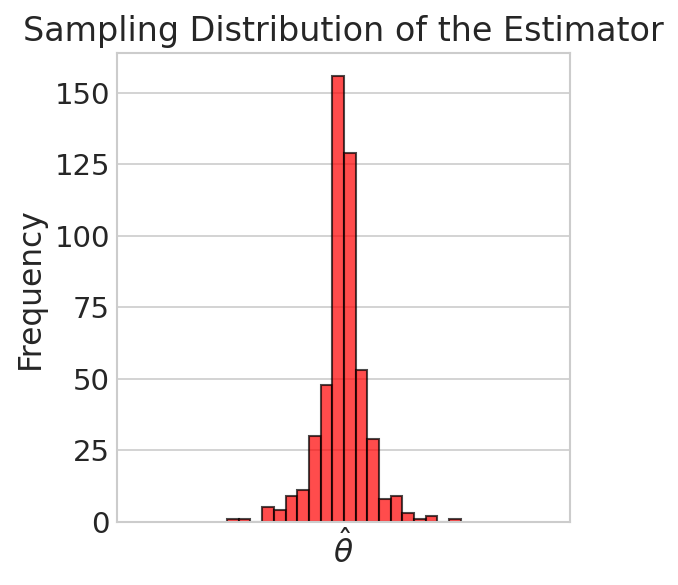

In [57]:
sample_means = y_prior_samples.mean(dim='data_dim').values.flatten()

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(sample_means, bins=20, color='red', alpha=0.7, edgecolor='black')

ax.set_xlim([-2, 2])
ax.set_xticks([])
ax.set_xlabel(r'$\hat{\theta}$')
ax.set_ylabel('Frequency')
ax.set_title('Sampling Distribution of the Estimator')

plt.tight_layout()
plt.savefig('sampling_distribution.jpg')
plt.show()

## 4. Null and MLE centered sampling distributions

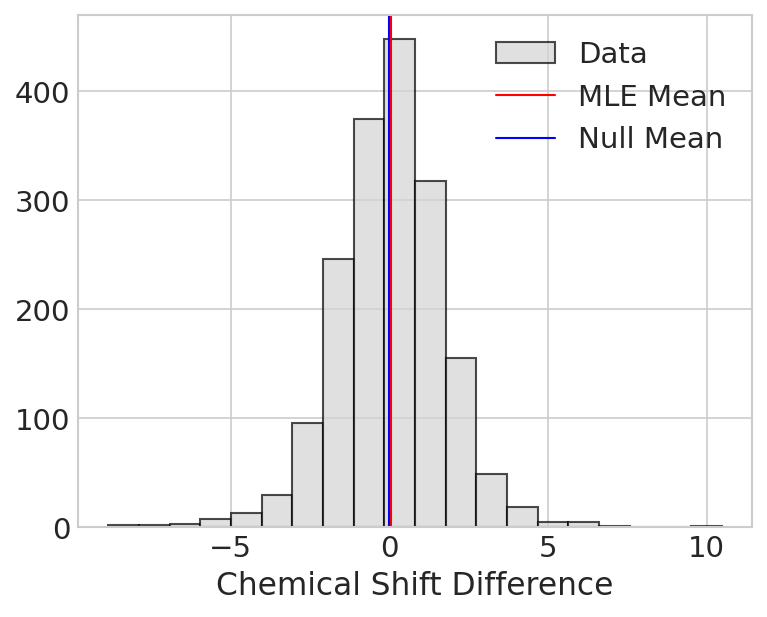

In [78]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(diff, bins=20, color='lightgray', edgecolor='black', alpha=0.7, label='Data')

mu_null_mu = 0
mu_mle_mu = np.mean(diff)

ax.axvline(mu_mle_mu, color='red', label=f'MLE Mean', linewidth=1)
ax.axvline(mu_null_mu, color='blue', label=f'Null Mean', linewidth=1)

ax.set_xlabel('Chemical Shift Difference')
ax.legend()
plt.show()

Sampling: [mu, sigma, y]
Sampling: [mu, sigma, y]
C:\Users\User\AppData\Local\Temp\ipykernel_25336\1801272734.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


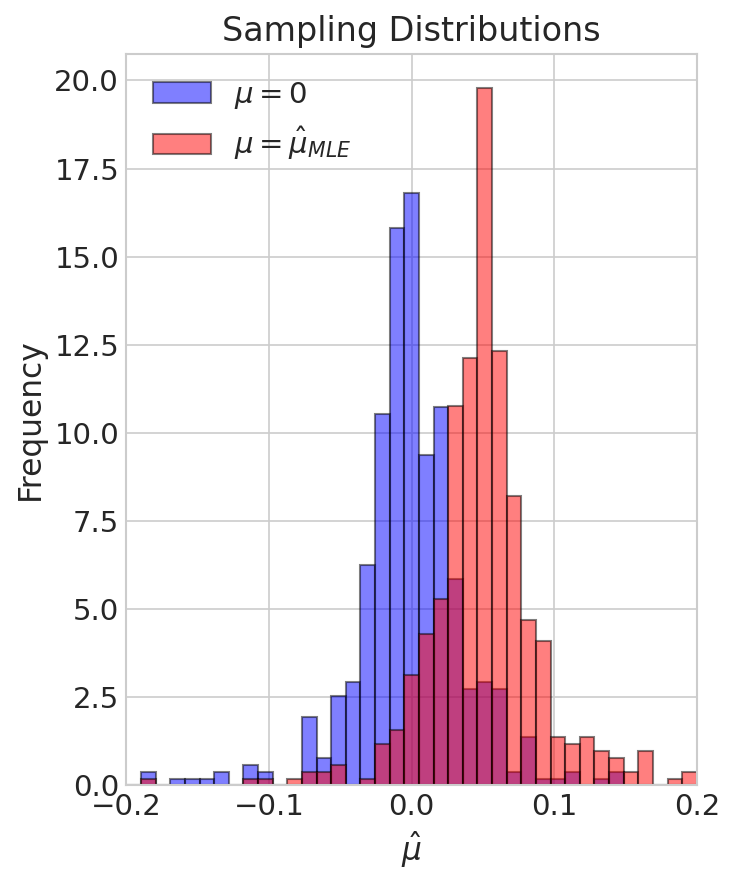

In [109]:

sigma_mu = 0.01
sigma_y = np.std(diff, ddof=1)
N = len(diff)
coords = {'data_dim': np.arange(N)}
num_draws = 500

# Sharp prior at the null value
with pm.Model(coords=coords) as model_null:
    mu = pm.Normal('mu', mu=mu_null_mu, sigma=sigma_mu)
    sigma = pm.HalfNormal('sigma', sigma=sigma_y)
    y = pm.Normal('y', mu=mu, sigma=sigma, dims='data_dim', observed=diff)
    prior_pred_null = pm.sample_prior_predictive(samples=num_draws, random_seed=123)

# Sharp prior at the MLE
with pm.Model(coords=coords) as model_mle:
    mu = pm.Normal('mu', mu=mu_mle_mu, sigma=sigma_mu)
    sigma = pm.HalfNormal('sigma', sigma=sigma_y)
    y = pm.Normal('y', mu=mu, sigma=sigma, dims='data_dim', observed=diff-mu_mle_mu)
    prior_pred_mle = pm.sample_prior_predictive(samples=num_draws, random_seed=456)

# Compute sample means
sample_means_null = prior_pred_null.prior_predictive['y'].mean(dim='data_dim').values.flatten()
sample_means_mle = prior_pred_mle.prior_predictive['y'].mean(dim='data_dim').values.flatten()

# Zoomed xlim
xlim_zoom = [-0.2, 0.2]
xbins = np.linspace(-0.2, 0.2, 40)
fig, ax = plt.subplots(figsize=(5, 6))
ax.hist(sample_means_null, bins=xbins, color='blue', alpha=0.5, density=True, edgecolor='black', label=r'$\mu = 0$')
ax.hist(sample_means_mle, bins=xbins, color='red', alpha=0.5, density=True, edgecolor='black', label=r'$\mu = \hat{\mu}_{MLE}$')
ax.set_xlim(xlim_zoom)
ax.set_xlabel(r'$\hat{\mu}$')
ax.set_ylabel('Frequency')
ax.set_title('Sampling Distributions')
ax.legend()
plt.tight_layout()
plt.show()



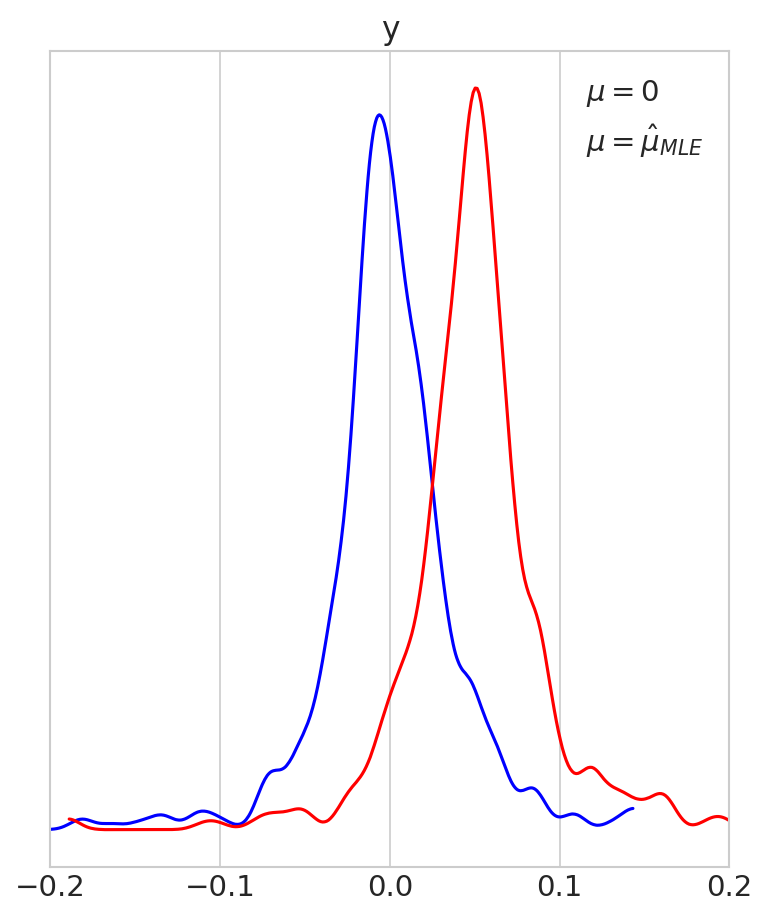

In [110]:
fig, ax = plt.subplots(figsize=(5, 6))

az.plot_bpv(prior_pred_null, kind='t_stat', t_stat='mean', 
            plot_mean=False, bpv=True, reference=None, smoothing=True, group='prior', 
            color='blue', ax=ax)
kde_line = [line for line in ax.get_lines() if line.get_label().startswith('bpv')][0]
kde_line.set_label(r'$\mu = 0$')

az.plot_bpv(prior_pred_mle, kind='t_stat', t_stat='mean', 
            plot_mean=False, bpv=True, reference=None, smoothing=True, group='prior', 
            color='red', ax=ax)
kde_line = [line for line in ax.get_lines() if line.get_label().startswith('bpv')][0]
kde_line.set_label(r'$\mu = \hat{\mu}_{MLE}$')

ax.set_xlim([-0.2, 0.2])
ax.legend()


Text(0.5, 1.0, 'Null model sampling distribution')

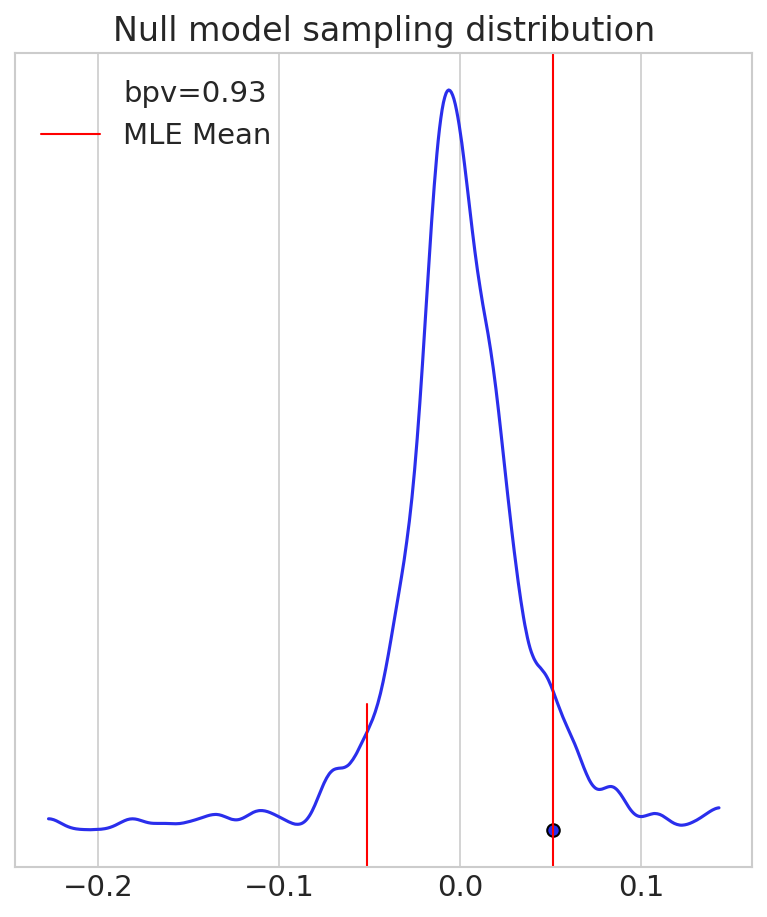

In [112]:
fig, ax = plt.subplots(figsize=(5, 6))

az.plot_bpv(prior_pred_null, kind='t_stat', t_stat='mean', reference=None, smoothing=True, group='prior', ax=ax)
ax.axvline(mu_mle_mu, color='red', label=f'MLE Mean', linewidth=1)
ax.axvline(-mu_mle_mu, ymin=0, ymax=0.2, color='red', linewidth=1)
ax.legend()
ax.set_title('Null model sampling distribution')

In [ ]:
l = ax.get_lines()
l[1].get_label()

True

## 5. Confidence intervals

### Create a "real" parameter value

In [133]:
alpha_value = 2 / 3
beta_value  = 2 / 3

with pm.Model() as true_parameter_model:
    theta = pm.Beta("theta", alpha=alpha_value, beta=beta_value)

    prior_predictive = pm.sample_prior_predictive(samples=1, random_seed=123)
    true_theta = prior_predictive.prior["theta"].item()
    
print(f"True θ: {true_theta:.4f}")

Sampling: [theta]


True θ: 0.1151


### Now sample some "real" data

In [134]:
with pm.Model() as real_data_model:
    real_data = pm.Binomial("real_data", n=10, p=true_theta)

    prior_pred = pm.sample_prior_predictive(samples=1, random_seed=123)
    y = prior_pred.prior["real_data"].item()

print("Real data:", y)

Sampling: [real_data]


Real data: 0


### Simulate fake data and show coverage property

In [152]:
import pytensor.tensor as pt

# Wilson score interval parameters
z = 1.96  # Z-value for 95% confidence
z2 = z**2


n=10
def symbolic_LH(d):
    term1 = (d + z2 / 2) / (n + z2)
    term2 = (z / (n + z2)) * pt.sqrt((d * (n - d)) / n + z2 / 4)
    L = term1 - term2
    H = term1 + term2
    return L, H

# 2. Numeric version for real data (using NumPy)
def numeric_LH(d):
    d = np.asarray(d, dtype=float)
    term1 = (d + z2 / 2) / (n + z2)
    term2 = (z / (n + z2)) * np.sqrt(np.clip(d * (n - d) / n + z2 / 4, 0, None))
    L = term1 - term2
    H = term1 + term2
    return L, H 


with pm.Model() as test_confidence_interval_model:
    simulated_data = pm.Binomial("simulated_data", n=n, p=true_theta)
    
    # Confidence bounds
    L, H = symbolic_LH(simulated_data)

    # Coverage indicator
    covered = pm.Deterministic("covered", (L <= true_theta) & (true_theta <= H))
    
    # Sample from the model
    prior_pred = pm.sample_prior_predictive(samples=5000, random_seed=123)

coverage = prior_pred.prior["covered"].mean()
print("Coverage:", coverage)

Sampling: [simulated_data]


Coverage: <xarray.DataArray 'covered' ()> Size: 8B
array(0.9784)


### Calculate actual confidence interval

In [156]:
CI = numeric_LH(y)
print(CI)

(np.float64(0.0), np.float64(0.2775401687666166))


### Test coverage across different $\theta$

In [174]:
coords = dict(
    true_theta_dim=np.arange(1000),
    sim_data_dim=np.arange(500)
)

with pm.Model(coords=coords) as coverage_model:
    true_theta = pm.Beta("true_theta", alpha=alpha_value, beta=beta_value, dims="true_theta_dim")
    simulated_data = pm.Binomial("simulated_data", n=n, p=true_theta[:, None], dims=("true_theta_dim", "sim_data_dim"))
    L, H = symbolic_LH(simulated_data)
    covered = pm.Deterministic("covered", (L <= true_theta[:, None]) & (true_theta[:, None] <= H), dims=("true_theta_dim", "sim_data_dim"))
    coverage = pm.Deterministic("coverage", covered.mean(axis=1), dims="true_theta_dim")
    prior_pred = pm.sample_prior_predictive(samples=1, random_seed=123)




Sampling: [simulated_data, true_theta]


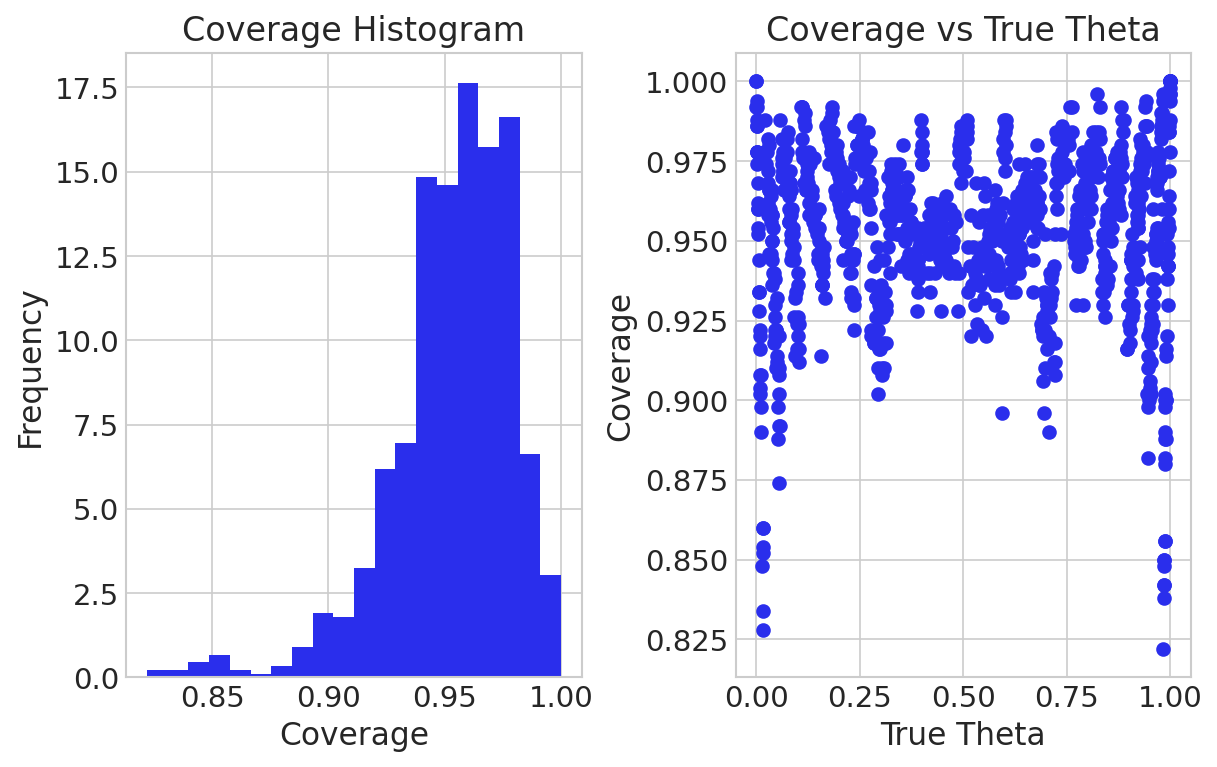

In [177]:
true_theta_vals = prior_pred.prior["true_theta"][0].values
coverage_vals   = prior_pred.prior["coverage"][0].values

fig, ax = plt.subplots(1, 2, figsize=(8, 5)) 

ax[0].hist(coverage_vals.T, bins=20, density=True)
ax[0].set_title("Coverage Histogram")
ax[0].set_xlabel("Coverage")
ax[0].set_ylabel("Frequency")

ax[1].scatter(true_theta_vals, coverage_vals)
ax[1].set_title("Coverage vs True Theta")
ax[1].set_xlabel("True Theta")
ax[1].set_ylabel("Coverage")
plt.show()

## Compare CIs and HDIs

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


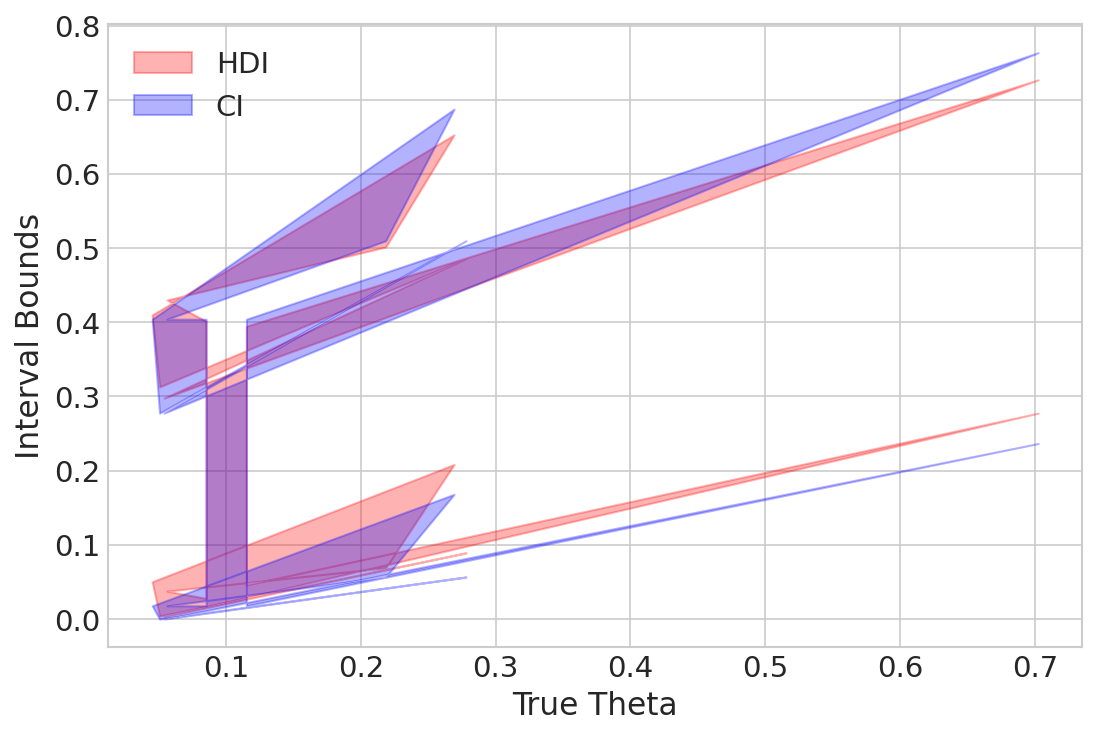

In [ ]:
num_datasets = 10

simulated_data_vals = prior_pred.prior["simulated_data"]
sim_data = simulated_data_vals.sel({'sim_data_dim': 0, 'true_theta_dim': range(num_datasets)}).values.flatten()
true_theta_vals = prior_pred.prior["true_theta"].sel({'true_theta_dim': range(num_datasets)}).values.flatten()

hdi_lows = np.zeros(num_datasets)
hdi_highs = np.zeros(num_datasets)
ci_lows = np.zeros(num_datasets)
ci_highs = np.zeros(num_datasets)


coords = {"dataset": np.arange(num_datasets)}

with pm.Model(coords=coords) as beta_binom_model:
    theta = pm.Beta("theta", alpha=2, beta=2, dims="dataset")
    y = pm.Binomial("y", n=n, p=theta, observed=sim_data, dims="dataset")
    
    idata = pm.sample(draws=500, tune=500, chains=2, random_seed=123, progressbar=True)


hdi = az.hdi(idata.posterior["theta"], hdi_prob=0.94)
hdi_lows = hdi.sel(hdi="lower")["theta"].values
hdi_highs = hdi.sel(hdi="higher")["theta"].values

# Wilson CI (still frequentist, one-by-one)
ci_lows = np.zeros(num_datasets)
ci_highs = np.zeros(num_datasets)
for i in range(num_datasets):
    cl, ch = sm.stats.proportion_confint(sim_data[i], n, alpha=0.05, method="wilson")
    ci_lows[i] = cl
    ci_highs[i] = ch



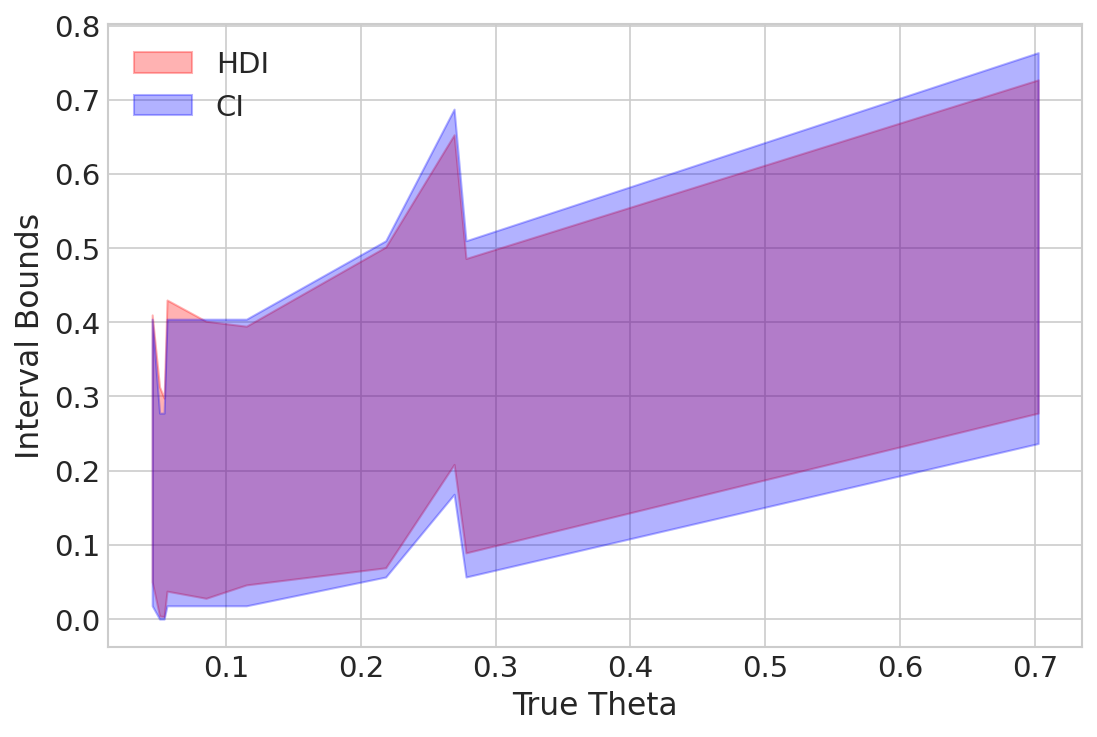

In [208]:
# Sort everything by true_theta_vals
sort_idx = np.argsort(true_theta_vals)
true_theta_vals_sorted = true_theta_vals[sort_idx]
hdi_lows_sorted = hdi_lows[sort_idx]
hdi_highs_sorted = hdi_highs[sort_idx]
ci_lows_sorted = ci_lows[sort_idx]
ci_highs_sorted = ci_highs[sort_idx]

plt.fill_between(true_theta_vals_sorted, hdi_lows_sorted, hdi_highs_sorted, color="red", alpha=0.3, label="HDI")
plt.fill_between(true_theta_vals_sorted, ci_lows_sorted, ci_highs_sorted, color="blue", alpha=0.3, label="CI")
plt.xlabel("True Theta")
plt.ylabel("Interval Bounds")
plt.legend()
plt.show()

## 7. Frequentist Linear Regression

In [215]:
# Baby growth data
baby_url = "https://raw.githubusercontent.com/aloctavodia/BAP3/refs/heads/main/code/data/babies.csv"
babies = pd.read_csv(baby_url)

import statsmodels.formula.api as smf

# Frequentist linear regression using Wilkinson notation
model_frequentist = smf.ols("length ~ month + I(month**2)", data=babies).fit()
print(model_frequentist.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     3540.
Date:                Wed, 11 Jun 2025   Prob (F-statistic):               0.00
Time:                        04:14:31   Log-Likelihood:                -2163.9
No. Observations:                 796   AIC:                             4334.
Df Residuals:                     793   BIC:                             4348.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        52.5567      0.326    161.091

## 8. Bayesian Linear Regression (Comparison)

In [216]:
model_bambi = bmb.Model("length ~ month + I(month**2)", data=babies)
idata_bambi = model_bambi.fit()
print(idata_bambi)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, month, I(month ** 2)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


c:\Repositories\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: month
C:\Users\User\AppData\Local\Temp\ipykernel_25336\2352474361.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


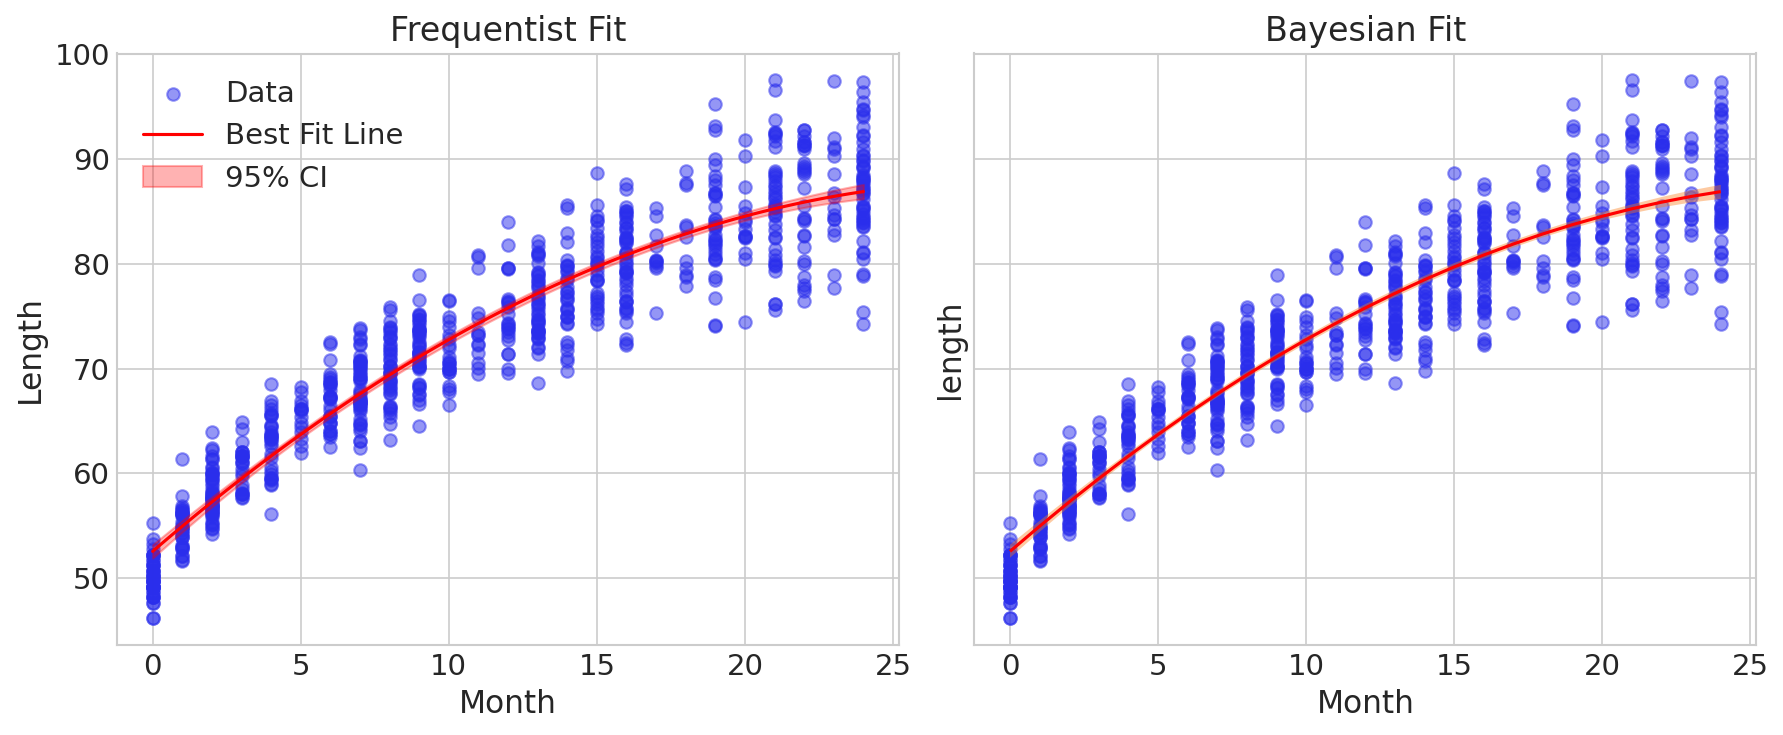

In [235]:
# Prepare x values for predictions
x_pred = np.linspace(babies.month.min(), babies.month.max(), 100)
x_pred_df = pd.DataFrame({"month": x_pred, "I(month ** 2)": x_pred ** 2})

# Frequentist predictions with confidence interval
pred_freq = model_frequentist.get_prediction(x_pred_df)
pred_freq_summary = pred_freq.summary_frame(alpha=0.05)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Frequentist plot
axes[0].scatter(babies.month, babies.length, alpha=0.5, label="Data")
axes[0].plot(x_pred, pred_freq_summary["mean"], color="red", label="Best Fit Line")
axes[0].fill_between(
    x_pred,
    pred_freq_summary["mean_ci_lower"],
    pred_freq_summary["mean_ci_upper"],
    color="red",
    alpha=0.3,
    label="95% CI"
)
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Length")
axes[0].set_title("Frequentist Fit")
axes[0].legend()

# Bayesian plot
axes[1].scatter(babies.month, babies.length, alpha=0.5)
bmb.interpret.plot_predictions(model_bambi, idata_bambi, ["month"], ax=axes[1])

line = axes[1].lines[0]
line.set_color("red")

axes[1].set_xlabel("Month")
axes[1].set_title("Bayesian Fit")
# axes[1].legend()

plt.tight_layout()
plt.show()

In [225]:
idata_bambi

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

c:\Repositories\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: month


(<Figure size 1080x720 with 1 Axes>,
 array([<Axes: xlabel='month', ylabel='length'>], dtype=object))

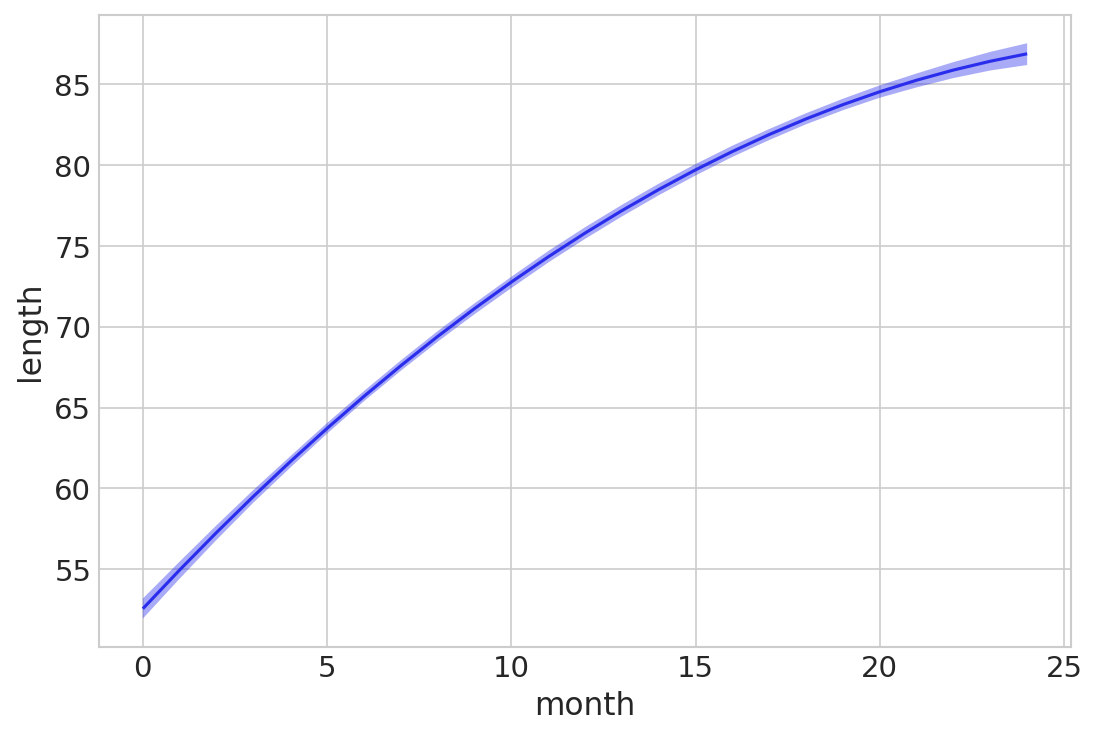

## 9. Summary
- Frequentist and Bayesian estimators
- CI vs. HDI
- Sampling distributions
- Linear regression comparison

This draft covers all the key figures and concepts outlined. Further adjustments can be made as needed!